# Ch 3a: Design Patterns 5 and 6

Design Pattern 5: Reframing

Design Pattern 6: Multilabel Classification

# Design Pattern 5: Reframing

Changing the representation (problem type) of a machine learning problem. For example, changing a typically regression problem into a classification problem and vice versa

In [ ]:
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv(dotenv_path=Path("../.env"))

In [1]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"../{os.environ.get('GCP_KEY_FILE')}"
bq = bigquery.Client()

In [2]:
import numpy as np
import seaborn as sns
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [3]:
bq = bigquery.Client()

In [4]:
query = """
SELECT
	weight_pounds,
	is_male,
	gestation_weeks,
	mother_age,
	plurality,
	mother_race
FROM
	`bigquery-public-data.samples.natality`
WHERE
	weight_pounds IS NOT NULL
	AND is_male = true
	AND gestation_weeks = 38
	AND mother_age = 28
	AND mother_race = 1
	AND plurality = 1
	AND RAND() < 0.01
"""

In [5]:
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,8.126239,True,38,28,1,1
1,8.875811,True,38,28,1,1
2,8.079942,True,38,28,1,1
3,8.562754,True,38,28,1,1
4,7.625790,True,38,28,1,1


Text(0.5, 0, 'weight_pounds')

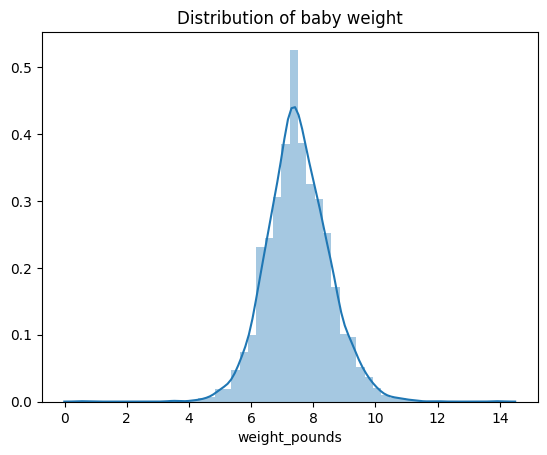

In [6]:
fig = sns.distplot(df[['weight_pounds']])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")

In [7]:
# Average weight
print(np.mean(df["weight_pounds"]))
print(np.std(df['weight_pounds']))

7.512945458362027
1.0033672282907988


## Comparing categorical labels and regression

Predicting baby weight as a regression problem and a classification problem by bucketizing the output labels. At inference, the model then predicts a collection of probabilities for each bucket

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model

In [4]:
df = pd.read_csv('data/babyweight_train.csv')

In [5]:
# Prepare inputs
df['is_male'] = df['is_male'].astype(str)
df['mother_race'].fillna(0, inplace=True)
df['mother_race'] = df['mother_race'].astype(str)

# Create categorical label
def categorical_weight(weight_pounds):
  if weight_pounds < 3.31:
    return 0
  elif weight_pounds >= 3.31 and weight_pounds < 5.5:
    return 1
  elif weight_pounds >= 5.5 and weight_pounds < 8.8:
    return 2
  else: return 3

df['weight_category'] = df['weight_pounds'].apply(lambda x: categorical_weight(x))
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,0.0,2


In [6]:
def encode_labels(classes):
  one_hots = to_categorical(classes)
  return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']
N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df[LABEL_CLS][:N_TRAIN])
y_train_reg = df[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df[LABEL_CLS][N_TRAIN:])
y_valid_reg = df[LABEL_REG][N_TRAIN:]

# train/validation dataset for classification model
cls_train_data = tf.data.Dataset.from_tensor_slices(
  (X_train.to_dict('list'), y_train_cls)
)
cls_valid_data = tf.data.Dataset.from_tensor_slices(
  (X_valid.to_dict('list'), y_valid_cls)
)

# train/validation dataset for regression model
reg_train_data = tf.data.Dataset.from_tensor_slices(
  (X_train.to_dict('list'), y_train_reg.values)
)
reg_valid_data = tf.data.Dataset.from_tensor_slices(
  (X_valid.to_dict('list'), y_valid_reg.values)
)

# Examine both datasets. Notice different label values
for data_type in [cls_train_data, reg_train_data]:
  for dict_slice in data_type.take(1):
    print(f"{dict_slice}\n")

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>)

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



In [7]:
# Create feature columns
numeric_columns = [fc.numeric_column("mother_age"),
                   fc.numeric_column("gestation_weeks")]
CATEGORIES = {
  'plurality': list(df['plurality'].unique()),
  'is_male': list(df['is_male'].unique()),
  'mother_race': list(df['mother_race'].unique()),
}								
categorical_columns = []
for feature, vocab in CATEGORIES.items():
  cat_col = fc.categorical_column_with_vocabulary_list(
    key=feature,
    vocabulary_list=vocab,
    dtype=tf.string
  )
  categorical_columns.append(fc.indicator_column(cat_col))

In [8]:
# Create inputs for model
inputs = {
	colname: tf.keras.layers.Input(
		name=colname,
		shape=(),
		dtype="float32"
	) for colname in ["mother_age", "gestation_weeks"]
}
inputs.update({
	colname: tf.keras.layers.Input(
		name=colname,
		shape=(),
		dtype=tf.string
	) for colname in ["plurality", "is_male", "mother_race"]
})

# Build DenseFeatures for model
dnn_inputs = layers.DenseFeatures(categorical_columns + numeric_columns)(inputs)
# hidden layers
h1 = layers.Dense(20, activation='relu')(dnn_inputs)
h2 = layers.Dense(10, activation='relu')(h1)

# Classification model
cls_output = layers.Dense(4, activation='softmax')(h2)
cls_model = Model(inputs=inputs, outputs=cls_output)
cls_model.compile(
	optimizer='adam',
	loss=tf.keras.losses.CategoricalCrossentropy(),
	metrics=['accuracy']
)

# Regression model
reg_output = layers.Dense(1, activation='relu')(h2)
reg_model = Model(inputs=inputs, outputs=reg_output)
reg_model.compile(
	optimizer='adam',
	loss=tf.keras.losses.MeanSquaredError(),
	metrics=['mse']
)

Training both models. First classification, then regression

In [9]:
# Train the classification model
cls_model.fit(cls_train_data.batch(50), epochs=1)

val_loss, val_accuracy = cls_model.evaluate(cls_valid_data.batch(X_valid.shape[0]))
print(f"Validation accuracy for classification model: {val_accuracy}")

1/1 [==============================] - 0s 391ms/step - loss: 0.8335 - accuracy: 0.6989
Validation accuracy for classification model: 0.6988838315010071


In [10]:
# Train the regression model
reg_model.fit(reg_train_data.batch(50), epochs=1)

val_loss, val_mse = reg_model.evaluate(reg_valid_data.batch(X_valid.shape[0]))
print(f'Validation RMSE for regression model: {val_mse ** 0.5}')

1/1 [==============================] - 0s 361ms/step - loss: 55.4446 - mse: 55.4446
Validation RMSE for regression model: 7.446109949177768


Run some predictions for both models

In [11]:
reg_preds = reg_model.predict(x={
	"gestation_weeks": tf.convert_to_tensor([38]),
	"is_male": tf.convert_to_tensor(["True"]),
	"mother_age": tf.convert_to_tensor([28]),
	"mother_race": tf.convert_to_tensor(["1.0"]),
	"plurality": tf.convert_to_tensor(["Single(1)"])
}, steps=1).squeeze()
reg_preds

1/1 [==============================] - 0s 338ms/step


array(0., dtype=float32)

1/1 [==============================] - 0s 155ms/step


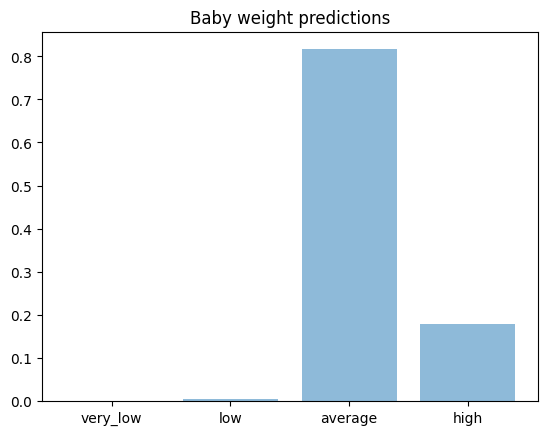

In [12]:
cls_preds = cls_model.predict(x={
	"gestation_weeks": tf.convert_to_tensor([38]),
	"is_male": tf.convert_to_tensor(["True"]),
	"mother_age": tf.convert_to_tensor([28]),
	"mother_race": tf.convert_to_tensor(["1.0"]),
	"plurality": tf.convert_to_tensor(["Single(1)"])
}, steps=1).squeeze()

objects = ('very_low', 'low', 'average', 'high')
y_pos = np.arange(len(objects))
predictions = list(cls_preds)

plt.bar(y_pos, predictions, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Baby weight predictions')

plt.show()

## Restricting the prediction range

Ensure that the output always falls within a specific range. Make the last-but-one activation function a sigmoid function and add a lambda layer to scale the (0, 1) values to the desired range.

A drawback is that it will be difficult for the neural network to reach extreme values, due to the shape of the sigmoid function, being difficult to reach larger values

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

MIN_Y =  3
MAX_Y = 20
input_size = 10
inputs = keras.layers.Input(shape=(input_size,))
h1 = keras.layers.Dense(20, 'relu')(inputs)
h2 = keras.layers.Dense(1, 'sigmoid')(h1)  # 0-1 range
output = keras.layers.Lambda(lambda y : (y*(MAX_Y-MIN_Y) + MIN_Y))(h2) # scaled
model = keras.Model(inputs, output)

# fit the model
model.compile(optimizer='adam', loss='mse')
batch_size = 2048
for i in range(0, 10):
    x = np.random.rand(batch_size, input_size)
    y = 0.5*(x[:,0] + x[:,1]) * (MAX_Y-MIN_Y) + MIN_Y
    model.fit(x, y)

# verify
min_y = np.finfo(np.float64).max
max_y = np.finfo(np.float64).min
for i in range(0, 10):
    x = np.random.randn(batch_size, input_size)
    y = model.predict(x)
    min_y = min(y.min(), min_y)
    max_y = max(y.max(), max_y)
print('min={} max={}'.format(min_y, max_y))

64/64 [==============================] - 0s 2ms/step
min=3.0009045600891113 max=19.965770721435547


# Design Pattern 6: Multilabel Classification

Models that can assign more than 1 label to a given input. The design requires change the activation function used in the final layer of the model and how the application will utilize the model output.

Notably different from multiclass classification problems, where a single input is assigned exactly one output label

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import bigquery

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"../{os.environ.get('GCP_KEY_FILE')}"
bq = bigquery.Client()

In [3]:
bq = bigquery.Client()

In [4]:
query = """
SELECT
	title,
	REPLACE(tags, "|", ",") as tags
FROM
	`bigquery-public-data.stackoverflow.posts_questions`
WHERE
	REGEXP_CONTAINS(
		tags,
		r"(?:keras|tensorflow|matplotlib|pandas|scikit-learn)"
	)
"""

In [5]:
df = bq.query(query).to_dataframe()
df.head()

,title,tags
0,Why is the shape of original dataframe changin...,"pandas,dataframe,copy"
1,Tensorflow 1: how to use the computation graph...,"python,tensorflow1.15"
2,Pandas Insert integer value into a variable,"python-3.x,pandas,dataframe"
3,How do i make a matplotlib table keep updating,"matplotlib,tkinter,ttkwidgets"
4,How to save the multi-labels of my image in on...,"python,pandas,csv"


In [9]:
import re
data = df.copy()
def remove_unwanted_tags(val, tags):
  val = val.split(',')
  removed = list(set(val).intersection(set(tags)))
  return ",".join(removed)
tags = ['keras', 'tensorflow', 'matplotlib', 'pandas', 'scikit-learn']
data['tags'] = data['tags'].apply(lambda x: remove_unwanted_tags(x, tags))

data['title'] = data['title'].apply( 
  lambda x: " ".join(["avocado" if word in tags else word for word in x.split(' ')])
)
      
data = data[data['tags'] != '']
data = shuffle(data, random_state=22)
data.head()

,title,tags
312984,Read from the specific lines of a csv in avocado,pandas
262818,regr.score and r2_score give different values,scikit-learn
114929,Insert avocado dataframe to sql database using...,pandas
1340,How To Categorize a List,pandas
83231,module 'keras.backend' has no attribute 'uniqu...,keras


In [10]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split[0])

['pandas']


In [11]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(df['title'].values[0][:110])
print(tag_encoder.classes_)
print(tags_encoded[0])

Why is the shape of original dataframe changing after copying into another dataframe?
['keras' 'matplotlib' 'pandas' 'scikit-learn' 'tensorflow']
[0 0 1 0 0]


In [12]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
print(f'Train size: {train_size}')
print(f'Test size: {len(data) - train_size}')

# Split labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

train_qns = data['title'].values[:train_size]
test_qns = data['title'].values[train_size:]

Train size: 346082
Test size: 86521


In [13]:
from tensorflow.keras.preprocessing import text

VOCAB_SIZE = 400
tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_qns)

body_train = tokenizer.texts_to_matrix(train_qns)
body_test = tokenizer.texts_to_matrix(test_qns)

In [14]:
# Using the sigmoid output with binary_crossentropy loss
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE, ), activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                20050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(body_train, train_tags, epochs=5, batch_size=128, validation_split=0.1)
print(f"Eval loss/accuracy: {model.evaluate(body_test, test_tags, batch_size=128)}")

Epoch 1/5
2434/2434 [==============================] - 18s 6ms/step - loss: 0.1731 - accuracy: 0.8157 - val_loss: 0.1520 - val_accuracy: 0.8354
Epoch 2/5
2434/2434 [==============================] - 17s 7ms/step - loss: 0.1481 - accuracy: 0.8362 - val_loss: 0.1496 - val_accuracy: 0.8349
Epoch 3/5
2434/2434 [==============================] - 16s 6ms/step - loss: 0.1457 - accuracy: 0.8383 - val_loss: 0.1486 - val_accuracy: 0.8331
Epoch 4/5
2434/2434 [==============================] - 15s 6ms/step - loss: 0.1440 - accuracy: 0.8394 - val_loss: 0.1485 - val_accuracy: 0.8358
Epoch 5/5
676/676 [==============================] - 3s 4ms/step - loss: 0.1462 - accuracy: 0.8398
Eval loss/accuracy: [0.14619207382202148, 0.8398076891899109]


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                20050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


## Parsing sigmoid results

Consider the thresholds for each class. Here a tag is associated if model is more than 70% confident

In [27]:
predictions = model.predict(body_test[:3])

1/1 [==============================] - 0s 22ms/step


In [32]:
classes = tag_encoder.classes_

for q_idx, probabilities in enumerate(predictions):
  print(test_qns[q_idx])
  for idx, tag_prob in enumerate(probabilities):
    if tag_prob > 0.7:
      print(classes[idx], round(tag_prob * 100, 2), '%')
  print("")

avocado "adding an op" debugging?
matplotlib 76.3 %

How to group row wise in a dataframe in avocado
pandas 99.93 %

Shape of passed value indices apply error on creating data frame
pandas 98.35 %

